# Introduction

In this post, we will discuss how to use data gathered from the Polygon and Yahoo Finance APIs to train machine learning models that will predict prospective features of the stock market.

For the purposes of this post, we will assume that the user has access to the .py files found in our github repository. However, we will still include important code from these files to explain how the models work. We will begin by importing important libraries.

In [1]:
import numpy as np
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
from keras import layers

import jax.numpy as jnp
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
import sys
import os

# Get the absolute path to the directory containing the .py files
module_path = os.path.abspath(os.path.join('..')) # Use relative or absolute path. '..' means one level up.

if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import polygon_interface
import yahoo_interface

In [4]:
pip install polygon-api-client

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install tensorflow_decision_forests

Note: you may need to restart the kernel to use updated packages.


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [7]:
import CNN_Maker
import LSTM_Maker
import Random_Forest_Maker

Note: most of the necessary code for creating the models is found in these imported modules.

# Acquiring and Processing Data

The following functions demonstrate how we obtain the data we need from the Polygon and Yahoo APIs.

First we have methods to create a table of data for a single stock, and methods to format the data.

In [8]:
def single_stock_table(ticker, start_date, end_date):
    """
    Returns a dataframe containing all available stock data from Yahoo Finance 
    for a given stock between start_date and end_date.
    Dates are in the format YYYY-MM-DD.
    """

    # Fetch stock data
    df = yf.download(ticker, start=start_date, end=end_date)

    # Reset index to get the Date as a column
    df.reset_index(inplace=True)

    # Rename columns to match the original function (except VWAP)
    df.rename(columns={
        'Date': 'Date',
        'Open': 'Open',
        'High': 'High',
        'Low': 'Low',
        'Close': 'Close',
        'Volume': 'Volume'
    }, inplace=True)
    
    # Convert the Date column to timestamps (milliseconds)
    df['Timestamp'] = df['Date'].astype('str').apply(date_to_timestamp)  # Convert to milliseconds
    
    # Rearrange columns (excluding VWAP)
    # Add this line inside the function to compute VWAP before rearranging columns
    df['Vwap'] = (df['High'] + df['Low'] + df['Close']) / 3
    df = df[['Timestamp', 'Date', 'Close', 'Volume', 'Open', 'High', 'Low', 'Vwap']]

    df = flatten_columns(df)
    
    return df

In [9]:
def flatten_columns(df):
    """Flattens MultiIndex column names by taking top-most name."""
    df.columns = df.columns.get_level_values(0)
    df.columns.name = None
    df.index.name = None
    return df

def exponential_smoothing(a, stock_data):
    """
    Applies exponential smoothing to each column (except timestamp and date) 
    of the dataframe
    0 < alpha < 1
    At alpha = 1, the smoothed data is equal to the initial data
    """
    stock_data[['Close', 'Volume', 'Open', 'High', 'Low']] = stock_data[['Close', 'Volume', 'Open', 'High', 'Low']].ewm(alpha = a, adjust = True).mean()
    return stock_data

The following functions extract important indicators of stock trends and the rise or fall of prices: MACD, RSI, Williams %R, and KDJ.

In [10]:
def fetch_macd(stock_ticker, start_date, end_date, short_window=12, long_window=26, signal_window=9):
    """
    Fetch MACD data for a given stock using yfinance.

    - If MACD > Signal Line → Upward trend (potential buy signal)
    - If MACD < Signal Line → Downward trend (potential sell signal)
    
    Parameters:
    - stock_ticker: Stock symbol (e.g., "AAPL")
    - start_date, end_date: Date range (YYYY-MM-DD)
    - short_window: Short-term EMA period (default=12)
    - long_window: Long-term EMA period (default=26)
    - signal_window: Signal line EMA period (default=9)
    """

    # Fetch stock data from Yahoo Finance
    df = yf.download(stock_ticker, start=start_date, end=end_date, interval="1d")

    # Compute short-term and long-term exponential moving averages (EMA)
    df['Short_EMA'] = df['Close'].ewm(span=short_window, adjust=False).mean()
    df['Long_EMA'] = df['Close'].ewm(span=long_window, adjust=False).mean()
    
    # Calculate MACD Line
    df['MACD Value'] = df['Short_EMA'] - df['Long_EMA']

    # Calculate Signal Line (9-day EMA of MACD)
    df['Signal'] = df['MACD Value'].ewm(span=signal_window, adjust=False).mean()
    
    # Convert Date index to a column and format
    df.reset_index(inplace=True)
        
    # Add timestamp column
    df['Timestamp'] = df['Date'].astype(str).apply(date_to_timestamp)
        
    # Select relevant columns
    df = df[['Timestamp', 'Date', 'MACD Value', 'Signal']]
    
    df = df.iloc[long_window - 1:]
        
    df = flatten_columns(df)
        
    return df

In [11]:
def fetch_rsi(stock_ticker, start_date, end_date, window=14):
    """
    Fetches the Relative Strength Index (RSI) for a given stock ticker using yfinance.
    
    - RSI > 70 → Overbought (potential price drop)
    - RSI < 30 → Oversold (potential price increase)
    
    Parameters:
    - stock_ticker: Ticker symbol (e.g., "AAPL")
    - start_date, end_date: Date range (YYYY-MM-DD)
    - window: Period for RSI calculation (default = 14)

    Returns:
    - DataFrame with RSI values
    """

    # Fetch stock data
    df = yf.download(stock_ticker, start=start_date, end=end_date, interval="1d")

    # Calculate price change
    df["Price Change"] = df["Close"].diff()

    # Calculate gains and losses
    df["Gain"] = df["Price Change"].apply(lambda x: x if x > 0 else 0)
    df["Loss"] = df["Price Change"].apply(lambda x: -x if x < 0 else 0)

    # Calculate rolling average gains and losses
    avg_gain = df["Gain"].rolling(window=window, min_periods=1).mean()
    avg_loss = df["Loss"].rolling(window=window, min_periods=1).mean()

    # Compute Relative Strength (RS)
    rs = avg_gain / avg_loss
    df["RSI Value"] = 100 - (100 / (1 + rs))

    # Convert Date index to a column and format
    df.reset_index(inplace=True)
        
    # Add timestamp column
    df['Timestamp'] = df['Date'].astype(str).apply(date_to_timestamp)
        
    # Select relevant columns
    df = df[["Timestamp", "Date", "RSI Value"]]
        
    df = flatten_columns(df)
    df = df.iloc[window - 1:]
    
    return df

In [12]:
def calculate_williams_r(stock_data, window=14):
    """
    Calculates Williams %R for the given stock data.
    
    - Above -20 → Overbought (Sell signal)
    - Below -80 → Oversold (Buy signal)
    
    Parameters:
    - stock_data: DataFrame containing "High", "Low", and "Close" columns.
    - window: The period over which Williams %R is calculated (default = 14 days).
        
    Returns:
    - DataFrame with an additional "Williams %R" column.
    """
    
    # Compute the highest high and lowest low over the window period
    highest_high = stock_data["High"].rolling(window=window, min_periods=1).max()
    lowest_low = stock_data["Low"].rolling(window=window, min_periods=1).min()
    
    # Calculate Williams %R
    stock_data["Williams %R"] = ((highest_high - stock_data["Close"]) / 
                                 (highest_high - lowest_low)) * -100

    return stock_data

In [13]:
def calculate_KDJ(stock_data, window_k_raw=9, window_d=3, window_k_smooth=3):
    """
    Calculates the KDJ indicators for a given stock dataset.

    - %K = Smoothed RSV (Relative Strength Value)
    - %D = Moving Average of %K
    - %J = 3 * %K - 2 * %D (momentum signal)

    Parameters:
    - stock_data: DataFrame from `single_stock_table()`
    - window_k_raw: Period for RSV calculation (default = 9 days)
    - window_d: Period for %D smoothing (default = 3 days)
    - window_k_smooth: Period for %K smoothing (default = 3 days)

    Returns:
    - DataFrame with %K, %D, and %J indicators added.
    """

    # Flatten column headers if they are multi-indexed
    if isinstance(stock_data.columns, pd.MultiIndex):
        stock_data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in stock_data.columns]

    # Ensure the dataset contains necessary columns (matching single_stock_table())
    required_columns = {"High", "Low", "Close"}
    if not required_columns.issubset(stock_data.columns):
        raise ValueError(f"Missing required columns: {required_columns - set(stock_data.columns)}. Available columns: {list(stock_data.columns)}")

    # Calculate RSV (Raw Stochastic Value)
    stock_data["H"] = stock_data["High"].rolling(window=window_k_raw, min_periods=1).max()
    stock_data["L"] = stock_data["Low"].rolling(window=window_k_raw, min_periods=1).min()

    # Prevent division by zero (if H == L, replace with 1 to avoid NaN)
    stock_data["RSV"] = ((stock_data["Close"] - stock_data["L"]) /
                         (stock_data["H"] - stock_data["L"]).replace(0, 1)) * 100

    # Calculate %K as a moving average of RSV
    stock_data["%K"] = stock_data["RSV"].rolling(window=window_k_smooth, min_periods=1).mean()

    # Calculate %D as a moving average of %K
    stock_data["%D"] = stock_data["%K"].rolling(window=window_d, min_periods=1).mean()

    # Calculate %J as a momentum signal
    stock_data["%J"] = 3 * stock_data["%K"] - 2 * stock_data["%D"]

    # Drop intermediate columns
    stock_data.drop(columns=["H", "L", "RSV"], inplace=True)

    return stock_data

Finally, our most important function: getting all the features of a given stock and returning a dataframe to be utilized in training the ML models.

In [14]:
def get_all_features(ticker, start_date, end_date, alpha = 0.8, smoothing = True,
                     macd_short_window=12, macd_long_window=26, macd_signal_window=9, 
                     rsi_window=14, 
                     williams_r_window=14, 
                     window_k_raw=9, window_d=3, window_k_smooth=3):
    """
    Returns a DataFrame with all stock indicators:
    - MACD (Moving Average Convergence Divergence)
    - RSI (Relative Strength Index)
    - Williams %R (Momentum indicator)
    - KDJ (Stock trend analysis)
    """
    
    basic_data = single_stock_table(ticker, start_date, end_date)
    macd_data = fetch_macd(ticker, start_date, end_date, 
                           macd_short_window, macd_long_window, macd_signal_window)
    rsi_data = fetch_rsi(ticker, start_date, end_date, rsi_window)
    
    # exponentially smooth data
    if smoothing:
        basic_data = exponential_smoothing(alpha, basic_data)

    #basic_data.rename(columns={"Date_": "Date"}, inplace=True)
    #macd_data.rename(columns={"Timestamp_": "Date"}, inplace=True)
    #rsi_data.rename(columns={"Timestamp_": "Date"}, inplace=True)

    df = pd.merge(basic_data, macd_data, how="inner", on=["Date", "Timestamp"])
    df = pd.merge(df, rsi_data, how="inner", on=["Date", "Timestamp"])

    high_col = [col for col in df.columns if "High" in col][0]
    low_col = [col for col in df.columns if "Low" in col][0]
    close_col = [col for col in df.columns if "Close" in col][0]
    
    df.rename(columns={high_col: "High", low_col: "Low", close_col: "Close"}, inplace=True)

    df = calculate_williams_r(df, williams_r_window)
    
    df = calculate_KDJ(df, window_k_raw, window_d, window_k_smooth)
    
    df = df.dropna().reset_index(drop = True)
    
    df = df[40:]
    
    return df

These functions will be called inside of the functions from the model maker modules, which is why we are not calling them here.

# Constructing and Training Models

Next, we will demonstrate how to make three different machine learning models: a CNN (Convolutional Neural Network) model, an LSTM (Long Short-Term Memory) model, and a Random Forest Regression model.

We will start with the CNN. The following functions are already contained in the CNN_maker module, but will also be shown here.

In [15]:
# used to create training sequences
def create_training_sequences(ticker, start_date, end_date, chunk_size = 365, smoothing = True, alpha = 0.5):
    """
    Returns a training set consisting of data from one stock ticker
        :param ticker: A string indicating a single stock ticker
        :param start_date: A string of the form YYYY-MM-DD specifying the start of the date range
        :param end_date: A string of the form YYYY-MM-DD specifying the end of the date range
        :param chunk_size: An integer specifying the number of records in each chunk 
        :param smoothing: A boolean indicating whether or not to apply exponential smoothing when calling yahoo_interface.get_all_features()
        :param alpha: A float in [0,1], i.e. the exponential smoothing parameter, which is passed to yahoo_interface.get_all_features()
    """
    
    # identify features used in model
    features = ['Close', 'High', 'Low', 'MACD Value', 'Signal', 'RSI Value', '%K', '%D', '%J', 'Williams %R']
    
    # get dataframe and targets
    df = yahoo_interface.get_all_features(ticker, start_date, end_date, smoothing = smoothing, alpha = alpha)
    df['Target'] = np.sign(df['Close'].shift(-1) - df['Close'])
    df = df.dropna()

    # define scaler and label encoder
    scaler = MinMaxScaler(feature_range = (0, 1))
    le = LabelEncoder()

    # initialize outputs
    X = []
    y = []

    # parse through chunks
    for i in range(len(df)//chunk_size + 1):
        # isolate a chunk
        df_chunk = df.iloc[i * chunk_size:(i + 1) * chunk_size].copy()
        for feature in features:
            data_chunk = df_chunk[feature]  # Get features in chunk
            scaled_chunk = scaler.fit_transform(data_chunk.values.reshape(-1, 1)).flatten() # Normalize selected feature chunk
            df_chunk.loc[data_chunk.index, feature] = scaled_chunk  # Assign to dataframe

        # create sequences
        for start in range(0, len(df_chunk) - 14):
            end = start + 14
            window = df_chunk[features].iloc[start: end].to_numpy()
            target = df_chunk['Target'].iloc[end]
            X.append(window)
            y.append(target)

    X = np.array(X, dtype = np.float32)
    y = le.fit_transform(y)

    return X, y

In [16]:
# same as create_training_sequences, but accepts multiple tickers
def create_training_sets(tickers, start_date, end_date, chunk_size = 365, smoothing = True, alpha = 0.5):
    """
    Returns a training set consisting of data from multiple stock tickers
        :param tickers: An array of strings representing stock tickers
        :param start_date: A string of the form YYYY-MM-DD specifying the start of the date range
        :param end_date: A string of the form YYYY-MM-DD specifying the end of the date range
        :param chunk_size: An integer specifying the number of records in each chunk 
        :param smoothing: A boolean indicating whether or not to apply exponential smoothing when calling yahoo_interface.get_all_features()
        :param alpha: A float in [0,1], i.e. the exponential smoothing parameter, which is passed to yahoo_interface.get_all_features()
    """
    
    # initialize output arrays
    X_train = np.empty((0,14,10), dtype = 'float64')
    y_train = np.empty((0), dtype = 'float64')
    
    # add to training set by calling create_training_sequences
    for ticker in tickers:
      X, y = create_training_sequences(ticker, '2000-01-01', '2025-01-01', alpha = 0.8)
      X_train = np.concatenate((X_train, X), axis = 0)
      y_train = np.concatenate((y_train, y), axis = 0)
    
    return X_train, y_train

In [17]:
# modified version of create_training_sequences which does not output target labels
def create_test_sequences(ticker, start_date, end_date, chunk_size = 365, smoothing = True, alpha = 0.5):
    """
    Returns a test set consisting of data from one stock ticker
        :param ticker: A string indicating a single stock ticker
        :param start_date: A string of the form YYYY-MM-DD specifying the start of the date range
        :param end_date: A string of the form YYYY-MM-DD specifying the end of the date range
        :param chunk_size: An integer specifying the number of records in each chunk 
        :param smoothing: A boolean indicating whether or not to apply exponential smoothing when calling yahoo_interface.get_all_features()
        :param alpha: A float in [0,1], i.e. the exponential smoothing parameter, which is passed to yahoo_interface.get_all_features()
    """
    
    # identify features used in model
    features = ['Close', 'High', 'Low', 'MACD Value', 'Signal', 'RSI Value', '%K', '%D', '%J', 'Williams %R']
    
    # get dataframe and targets
    df = yahoo_interface.get_all_features(ticker, start_date, end_date, smoothing = smoothing, alpha = alpha)
    df['Target'] = np.sign(df['Close'].shift(-1) - df['Close'])
    df = df.dropna()

    # define scaler and label encoder
    scaler = MinMaxScaler(feature_range = (0, 1))
    le = LabelEncoder()

    # initialize output
    X = []

    # parse through chunks
    for i in range(len(df)//chunk_size + 1):
        # isolate a chunk
        df_chunk = df.iloc[i * chunk_size:(i + 1) * chunk_size].copy()
        for feature in features:
            data_chunk = df_chunk[feature]  # Get features in chunk
            scaled_chunk = scaler.fit_transform(data_chunk.values.reshape(-1, 1)).flatten() # Normalize selected feature chunk
            df_chunk.loc[data_chunk.index, feature] = scaled_chunk  # Assign to dataframe

        # create sequences
        for start in range(0, len(df_chunk) - 14):
            end = start + 14
            window = df_chunk[features].iloc[start: end].to_numpy()
            target = df_chunk['Target'].iloc[end]
            X.append(window)

    X = np.array(X, dtype = np.float32)

    return X

In [18]:
def create_CNN(imported_weights = None, training_set = None):
    """
    Creates and returns a CNN model trained in one of two ways:
        if imported_weights is specified, then weights are loaded in using model.load_weights()
        if training_set is specified, then model is trained using model.fit()
    If both ways are specified, then imported_weights takes precedence
    If none of the two ways are specified, then method calls create_training_sets
    to create a training set.
        :param imported_weights: a string ending in '.weights.h5', indicating the name of a weights file which is compatible with the architecture of the LSTM model below
        :param training_set: a tuple of the form (X_train, y_train), where X_train is a numpy array of size (n, 14, 10) and y_train is of size (n,), where n is the number of records in the training data
    """
    
    # create model
    model = keras.Sequential([
        layers.Input((14, 10, 1)),
        layers.Conv2D(32, (3, 3), padding = 'same', activation='relu'),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), padding = 'same', activation='relu'),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), padding = 'same',activation='relu'),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dense(2)
    ])
    
    # compile model
    model.compile(optimizer = 'adam',
              loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])
    
    # if weights specified, import
    if imported_weights != None:
        model.load_weights(imported_weights)
    # if training set specified, fit to training data
    elif training_set != None:
        model.fit(training_set[0], training_set[1], epochs = 50)
    # otherwise, train with the following defualt data set
    else:
        tickers = ['AAPL', 'COST', 'CVX', 'WM', 'LLY']
        start_date = '2000-01-01' 
        end_date = '2025-03-10'
        X_train, y_train = create_training_sets(tickers, start_date, end_date, 
                                                chunk_size = 365, smoothing = True, alpha = 0.5)
        model.fit(X_train, y_train, epochs = 50)
        
    return model

In [19]:
class CNN_Wrapper:
    def __init__(self, imported_weights = None, training_set = None):
        self.model = create_CNN(imported_weights, training_set)
        
    def evaluate(self, ticker, start_date, end_date, smoothing = True, alpha = 0.5):
        """
        Tests model accuracy against stock data on a specified ticker over a specified range
            :param ticker: A string indicating a single stock ticker
            :param start_date: A string of the form YYYY-MM-DD specifying the start of the date range
            :param end_date: A string of the form YYYY-MM-DD specifying the end of the date range
            :param chunk_size: An integer specifying the number of records in each chunk 
            :param smoothing: A boolean indicating whether or not to apply exponential smoothing when calling yahoo_interface.get_all_features()
            :param alpha: A float in [0,1], i.e. the exponential smoothing parameter, which is passed to yahoo_interface.get_all_features()
        """
        
        # create test set
        X_test, y_test = create_training_sequences(ticker, start_date, end_date, smoothing = smoothing, alpha = alpha)
        
        # evaluate model
        self.model.evaluate(X_test, y_test)

    def predict(self, ticker):
        """
        Predicts whether or not a stock's current closing price will rise or fall tomorrow
            :param ticker: a string specifying a stock ticker
        """
        
        # identify classes
        classes = ['Rise', 'Fall']
        
        # get today's timestamp
        current_timestamp = datetime.now().timestamp()*1000
        
        # get timestamp for 5 months back (used to compute features)
        past_timestamp = current_timestamp - 86400 * 31 * 5 * 1000
        
        # convert timestamps to strings of form YYYY-MM-DD
        current_date = yahoo_interface.timestamp_to_date(current_timestamp)
        past_date = yahoo_interface.timestamp_to_date(past_timestamp)
        
        # get sequences to be fed into model
        X_test = create_test_sequences(ticker, past_date, current_date, smoothing = False)
        
        # get predictions
        y_pred = self.model.predict(X_test)
        
        # apply argmax 
        labels = y_pred.argmax(axis = 1)
        
        # output prediction
        return classes[labels.item(-1)]

Next is the LSTM model (again, these functions are all found in the LSTM_Maker module).

In [20]:
# Used to keep values in [0,1]
def proj(x, a, b):
  """
  Projects a number x onto the interval [a,b]
  Values in [a,b] are projected onto themselves
  Values less than a are projected onto a
  Values greater than b are projected onto b
    :param x: number to be projected onto [a,b]
    :param a: left endpoint of interval [a,b]
    :param b: right endpoint of interval [a,b]
  """
  return max(min(x, b), a)

In [21]:
# Used to add noise to stock predictions
def noise():
    """
    Takes one sample of a normal distribution with mean 0, stdev = 0.33, projected onto [-1,1]
    """
    value = np.random.normal(0, 0.33, 1)
    return proj(value, -1,1 )

In [22]:
# function for creating training sequences to feed into model
def create_training_sequences(data, window_size = 60):
    """
      Returns a list of windows in data of length window_size
          and a list containing corresponding to the data value immediately proceeding a window

      :param data: a numpy array of shape (n, 1), e.g. closing_prices
      :param window_size: length of window
    """

    # initialize output lists
    X, y = [], []
    
    # take observations
    for i in range(len(data) - window_size):
        X.append(data[i: i + window_size, 0])    # closing prices in last (seq_length)-days
        y.append(data[i + window_size, 0])       # closing price in day after the x-sequence
    return np.array(X), np.array(y)

In [23]:
# function for creating training sets
def create_training_sets(tickers, start_date, end_date, chunk_size = 365, smoothing = True, alpha = 0.5):
    """
    Returns a training set and associated targets.    
        :param tickers: An array of strings representing stock tickers. This specifies which stocks to get observations from.
        :param start_date: A string of the form YYYY-MM-DD specifying the start of the date range
        :param end_date: A string of the form YYYY-MM-DD specifying the end of the date range
        :param chunk_size: An integer specifying the number of records in each chunk 
        :param smoothing: A boolean indicating whether or not to apply exponential smoothing when calling yahoo_interface.get_all_features()
        :param alpha: A float in [0,1], i.e. the exponential smoothing parameter, which is passed to yahoo_interface.get_all_features()
    """
    
    window_size = 60
    X_train = np.empty((0,60), dtype = 'float64')
    y_train = np.empty((0), dtype = 'float64')
    
    for ticker in tickers:
      df = yahoo_interface.get_all_features(ticker, start_date, end_date, smoothing = smoothing, alpha = alpha)
      for i in range(len(df)//chunk_size):
        # get chunk of dataframe
        df_chunk = df[i*chunk_size: min((i+1)*chunk_size, len(df))]
    
        # Put closing prices into numpy array
        closing_prices = df_chunk['Close'].values.reshape(-1, 1)
    
        # Normalize the data between [0,1]
        scaler = MinMaxScaler(feature_range = (0, 1))
        scaled_data = scaler.fit_transform(closing_prices)
        
        X, y = create_training_sequences(scaled_data, window_size)
        X_train = np.concatenate((X_train, X))
        y_train = np.concatenate((y_train, y))

    return X_train, y_train

In [24]:
# function for creating training/validation sets
def create_training_and_val_sets(tickers, start_date, end_date, chunk_size = 365, smoothing = True, alpha = 0.5, split = 0.7):
    """
    Returns a training and validation sets.    
        :param tickers: An array of strings representing stock tickers. This specifies which stocks to get observations from.
        :param start_date: A string of the form YYYY-MM-DD specifying the start of the date range
        :param end_date: A string of the form YYYY-MM-DD specifying the end of the date range
        :param chunk_size: An integer specifying the number of records in each chunk 
        :param smoothing: A boolean indicating whether or not to apply exponential smoothing when calling yahoo_interface.get_all_features()
        :param alpha: A float in [0,1], i.e. the exponential smoothing parameter, which is passed to yahoo_interface.get_all_features()
        :param split: A float in [0,1] indicating what portion of the data is to be used for training vs validation
    """
    
    window_size = 60
    X_train = np.empty((0,60), dtype = 'float64')
    y_train = np.empty((0), dtype = 'float64')
    
    X_val = np.empty((0,60), dtype = 'float64')
    y_val = np.empty((0), dtype = 'float64')
    
    for ticker in tickers:
      df = yahoo_interface.get_all_features(ticker, start_date, end_date, smoothing = smoothing, alpha = alpha)
      for i in range(len(df)//chunk_size):
        # get chunk of dataframe
        df_chunk = df[i*chunk_size: min((i+1)*chunk_size, len(df))]
    
        # Put closing prices into numpy array
        closing_prices = df_chunk['Close'].values.reshape(-1, 1)
    
        # Normalize the data between [0,1]
        scaler = MinMaxScaler(feature_range = (0, 1))
        scaled_data = scaler.fit_transform(closing_prices)
    
        train_size = int(len(df_chunk) * split)
        train, val = scaled_data[: train_size, :], scaled_data[train_size:, :]
        
        X, y = create_training_sequences(train, window_size)
        X_train = np.concatenate((X_train, X))
        y_train = np.concatenate((y_train, y))
        
        X, y = create_training_sequences(val, window_size)
        X_val = np.concatenate((X_val, X))
        y_val = np.concatenate((y_val, y))
    
    return X_train, y_train, X_val, y_val

In [25]:
# modified version of create_training_sequences. Only outputs X array, not y array
def create_sequences(data, window_size = 60):
    
    """
      Returns a list of windows in data of length window_size
          and a list containing corresponding to the data value immediately proceeding a window

      :param data: a numpy array of shape (n, 1), e.g. closing_prices
      :param window_size: length of window
    """

    X = []
    for i in range(len(data) - window_size + 1):
        X.append(data[i: i + window_size, 0])    # closing prices in last (seq_length)-days
    return np.array(X)

In [26]:
# creates LSTM model
def create_LSTM(imported_weights = None, training_set = None):
    """
    Creates and returns an LSTM model trained in one of two ways:
        if imported_weights is specified, then weights are loaded in using model.load_weights()
        if training_set is specified, then model is trained using model.fit()
    If both ways are specified, then imported_weights takes precedence
    If none of the two ways are specified, then method calls create_training_sets
    to create a training set.
        :param imported_weights: a string ending in '.weights.h5', indicating the name of a weights file which is compatible with the architecture of the LSTM model below
        :param training_set: a tuple of the form (X_train, y_train), where X_train is a numpy array of size (n, 60) and y_train is of size (n,), where n is the number of records in the training data
    """
    
    # create model
    model = keras.Sequential([
        layers.LSTM(32, return_sequences = True, input_shape = (60, 1)),
        layers.Dropout(0.2),
        layers.LSTM(64),
        layers.Dropout(0.2),
        layers.Dense(32, activation = 'relu'),
        layers.Dropout(0.2),
        layers.Dense(1)
    ])
    
    # compile model
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    
    # if weights specified, import and return
    if imported_weights != None:
        model.load_weights(imported_weights)
    elif training_set != None:
        model.fit(training_set[0], training_set[1], epochs = 50)
    else:
        tickers = ['AAPL', 'COST', 'CVX', 'WM', 'LLY']
        start_date = '2000-01-01' 
        end_date = '2025-03-10'
        X_train, y_train = create_training_sets(tickers, start_date, end_date, 
                                                chunk_size = 365, smoothing = True, alpha = 0.5)
        model.fit(X_train, y_train, epochs = 50)
        
    return model

In [27]:
class LSTM_wrapper:
    def __init__(self, imported_weights = None, training_set = None):
        self.model = create_LSTM(imported_weights, training_set)
        
    def line_plot_evaluation(self, tickers, start_date, end_date):
        scaler = MinMaxScaler(feature_range = (0, 1))
        
        plt.figure(figsize = (20,10))
        for i in range(6):
          # reading data
          df = yahoo_interface.get_all_features(f'{tickers[i]}', start_date, end_date, smoothing = False)
          closing_prices = df['Close'].values.reshape(-1, 1)
          scaled_data = scaler.fit_transform(closing_prices)
        
          # formatting data to be fed into model
          window_size = 60
          X_full = create_sequences(scaled_data, window_size)
        
          # getting predictions
          full_predict = self.model.predict(X_full)
          full_predict = scaler.inverse_transform(full_predict)
          mse = mean_squared_error(closing_prices[59:], full_predict)
        
          # Plotting real vs predicted prices
          known_plot = np.empty((closing_prices.shape[0] + 1, 1))
          known_plot[:, :] = np.nan
          known_plot[:closing_prices.shape[0], :] = closing_prices
        
          prediction_plot = np.empty((closing_prices.shape[0] + 1, 1))
          prediction_plot[:, :] = np.nan
          prediction_plot[window_size: closing_prices.shape[0] + 1, :] = full_predict
        
          # set up subplots
          plt.subplot(2,3,i+1)
          plt.title(f'{tickers[i]}')
          plt.plot(known_plot, color = 'blue', label = 'Actual Price')
          plt.plot(prediction_plot, color = 'orange', label = f'Predicted Price (MSE = {mse:.4f})')
          plt.legend()
        
        plt.show()
        
    def forecast(self, stock_data, days_forward = 60):
        """
        Generates predictions for a stock given 60 days of historical data
        Returns an appended version of scaled_data with predictions appearing at the end of the array
            :param stock_data: a dataframe containing a column titled 'Close', with at least 60 rows
            :param days_forward: the number of days in the future we want to forecast
        """
        scaler = MinMaxScaler(feature_range = (0, 1))
        scaled_data = scaler.fit_transform(stock_data['Close'].values.reshape(-1, 1))
        
        # initialize array to store future values
        forecast_arr = scaled_data
        
        # get predictions
        for i in range(days_forward):
            # get last 60 days in array
            seq = create_sequences(forecast_arr[-60:], 60)
        
            # predict next day using model
            one_predict = self.model.predict(seq, verbose = 0)
        
            # add noise to prediction
            updated_value = np.array(one_predict[0][0].item()*(1 + 0.1 * noise()))
            one_predict[0][0] = updated_value.item()
        
            # add prediction to array
            forecast_arr = np.concatenate((forecast_arr, one_predict))
        
        # reverse data scaling
        forecast_arr = scaler.inverse_transform(forecast_arr)
        
        return forecast_arr
        
    def forecast_ensemble(self, stock_data, days_forward = 60, size = 10):
        """
        Calls forecast() several times and returns a list of forecast arrays
            :param stock_data: a dataframe containing a column titled 'Close', with at least 60 rows
            :param days_forward: the number of days in the future we want to forecast
            :param size: size of output list, i.e. number of times forecast() is called
        """
        forecast_list = []
        for i in range(size):
            forecast_list.append(self.forecast(stock_data = stock_data, days_forward = days_forward))

        return forecast_list

Just like the previous two models, the functions for the Random Forest model are found in the Random_Forest_Maker module.

In [28]:
# Used to keep values in [0,1]
def proj(x, a, b):
  """
  Projects a number x onto the interval [a,b]
  Values in [a,b] are projected onto themselves
  Values less than a are projected onto a
  Values greater than b are projected onto b
    :param x: number to be projected onto [a,b]
    :param a: left endpoint of interval [a,b]
    :param b: right endpoint of interval [a,b]
  """
  return max(min(x, b), a)    

In [29]:
# Used to add noise to stock predictions
def noise():
    """
    Takes one sample of a normal distribution with mean 0, stdev = 0.33, projected onto [-1,1]
    """
    value = np.random.normal(0, 0.33, 1)
    return proj(value, -1,1 )

In [30]:
# function for creating training sequences to feed into model
def create_training_sequences(data, window_size = 60):
    """
      Returns a list of windows in data of length window_size
          and a list containing corresponding to the data value immediately proceeding a window

      :param data: a numpy array of shape (n, 1), e.g. closing_prices
      :param window_size: length of window
    """

    # initialize output lists
    X, y = [], []
    
    # take observations
    for i in range(len(data) - window_size):
        X.append(data[i: i + window_size, 0])    # closing prices in last (seq_length)-days
        y.append(data[i + window_size, 0])       # closing price in day after the x-sequence
    return np.array(X), np.array(y)

In [31]:
# function for creating training sets
def create_training_sets(tickers, start_date, end_date, chunk_size = 365, smoothing = True, alpha = 0.5):
    """
    Returns a training set and associated targets.    
        :param tickers: An array of strings representing stock tickers. This specifies which stocks to get observations from.
        :param start_date: A string of the form YYYY-MM-DD specifying the start of the date range
        :param end_date: A string of the form YYYY-MM-DD specifying the end of the date range
        :param chunk_size: An integer specifying the number of records in each chunk 
        :param smoothing: A boolean indicating whether or not to apply exponential smoothing when calling yahoo_interface.get_all_features()
        :param alpha: A float in [0,1], i.e. the exponential smoothing parameter, which is passed to yahoo_interface.get_all_features()
    """
    
    window_size = 60
    X_train = np.empty((0,60), dtype = 'float64')
    y_train = np.empty((0), dtype = 'float64')
    
    for ticker in tickers:
      df = yahoo_interface.get_all_features(ticker, start_date, end_date, smoothing = smoothing, alpha = alpha)
      for i in range(len(df)//chunk_size):
        # get chunk of dataframe
        df_chunk = df[i*chunk_size: min((i+1)*chunk_size, len(df))]
    
        # Put closing prices into numpy array
        closing_prices = df_chunk['Close'].values.reshape(-1, 1)
    
        # Normalize the data between [0,1]
        scaler = MinMaxScaler(feature_range = (0, 1))
        scaled_data = scaler.fit_transform(closing_prices)
        
        X, y = create_training_sequences(scaled_data, window_size)
        X_train = np.concatenate((X_train, X))
        y_train = np.concatenate((y_train, y))

    return X_train, y_train

In [32]:
# function for creating training/validation sets
def create_training_and_val_sets(tickers, start_date, end_date, chunk_size = 365, smoothing = True, alpha = 0.5, split = 0.7):
    """
    Returns a training and validation sets.    
        :param tickers: An array of strings representing stock tickers. This specifies which stocks to get observations from.
        :param start_date: A string of the form YYYY-MM-DD specifying the start of the date range
        :param end_date: A string of the form YYYY-MM-DD specifying the end of the date range
        :param chunk_size: An integer specifying the number of records in each chunk 
        :param smoothing: A boolean indicating whether or not to apply exponential smoothing when calling yahoo_interface.get_all_features()
        :param alpha: A float in [0,1], i.e. the exponential smoothing parameter, which is passed to yahoo_interface.get_all_features()
        :param split: A float in [0,1] indicating what portion of the data is to be used for training vs validation
    """
    
    window_size = 60
    X_train = np.empty((0,60), dtype = 'float64')
    y_train = np.empty((0), dtype = 'float64')
    
    X_val = np.empty((0,60), dtype = 'float64')
    y_val = np.empty((0), dtype = 'float64')
    
    for ticker in tickers:
      df = yahoo_interface.get_all_features(ticker, start_date, end_date, smoothing = smoothing, alpha = alpha)
      for i in range(len(df)//chunk_size):
        # get chunk of dataframe
        df_chunk = df[i*chunk_size: min((i+1)*chunk_size, len(df))]
    
        # Put closing prices into numpy array
        closing_prices = df_chunk['Close'].values.reshape(-1, 1)
    
        # Normalize the data between [0,1]
        scaler = MinMaxScaler(feature_range = (0, 1))
        scaled_data = scaler.fit_transform(closing_prices)
    
        train_size = int(len(df_chunk) * split)
        train, val = scaled_data[: train_size, :], scaled_data[train_size:, :]
        
        X, y = create_training_sequences(train, window_size)
        X_train = np.concatenate((X_train, X))
        y_train = np.concatenate((y_train, y))
        
        X, y = create_training_sequences(val, window_size)
        X_val = np.concatenate((X_val, X))
        y_val = np.concatenate((y_val, y))
    
    return X_train, y_train, X_val, y_val

In [33]:
# modified version of create_training_sequences. Only outputs X array, not y array
def create_sequences(data, window_size = 60):
    """
      Returns a list of windows in data of length window_size
          and a list containing corresponding to the data value immediately proceeding a window

      :param data: a numpy array of shape (n, 1), e.g. closing_prices
      :param window_size: length of window
    """

    X = []
    for i in range(len(data) - window_size + 1):
        X.append(data[i: i + window_size, 0])    # closing prices in last (seq_length)-days
    return np.array(X)

In [34]:
def create_random_forest(X_train, y_train, 
                           n_estimators=100, 
                           max_depth=None, 
                           min_samples_split=2, 
                           min_samples_leaf=1, 
                           random_state=42):
    """Creates, trains, and returns a RandomForestRegressor model."""
    model = RandomForestRegressor(n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  min_samples_split=min_samples_split,
                                  min_samples_leaf=min_samples_leaf,
                                  random_state=random_state)
    model.fit(X_train, y_train)
    return model

In [35]:
class Random_Forest_wrapper:
    def __init__(self, X_train, y_train):
        self.model = create_random_forest(X_train, y_train)
   
    def mse_evaluation(self, X_val, y_val):
        """
        Makes predictions and evaluates the model's performance.
        """
        
        y_pred = self.model.predict(X_val)
    
        mse = mean_squared_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)
    
        print(f"Mean Squared Error (MSE): {mse}")
        print(f"R-squared (R2): {r2}")
    
        return y_pred
    
    def scatter_plot_evaluation(self, y_val, y_pred):
        """
        Creates a scatter plot of actual vs. predicted values.
        """
        plt.scatter(y_val, y_pred)
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.title("Actual vs. Predicted Values (Random Forest Regression)")
        plt.show()
        
    def line_plot_evaluation(self, tickers, start_date, end_date):
        """
        Creates a line plot comparing actual vs predicted prices against multiple stocks
        """
        scaler = MinMaxScaler(feature_range = (0, 1))
        
        plt.figure(figsize = (15,10))
        for i in range(6):
            # reading data
            df = yahoo_interface.get_all_features(f'{tickers[i]}', '2024-01-01', '2025-01-01', smoothing = False)
            closing_prices = df['Close'].values
            closing_prices = closing_prices[:,np.newaxis]
            scaled_data = scaler.fit_transform(closing_prices)
        
            # formatting data to be fed into model
            window_size = 60
            X_full = create_sequences(scaled_data, window_size)
        
            # getting predictions
            full_predict = self.model.predict(X_full)
            full_predict = full_predict[:,np.newaxis]
            full_predict = scaler.inverse_transform(full_predict)
        
            # Plotting real vs predicted prices
            known_plot = np.empty((closing_prices.shape[0] + 1, 1))
            known_plot[:, :] = np.nan
            known_plot[:closing_prices.shape[0], :] = closing_prices
        
            prediction_plot = np.empty((closing_prices.shape[0] + 1, 1))
            prediction_plot[:, :] = np.nan
            prediction_plot[window_size: closing_prices.shape[0] + 1, :] = full_predict
        
            # set up subplots
            plt.subplot(2,3,i+1)
            plt.title(f'{tickers[i]}')
            plt.plot(known_plot, color = 'blue', label = 'Actual Price')
            plt.plot(prediction_plot, color = 'orange', label = 'Predicted Price')
            plt.legend()
        
        plt.show()
        
    def forecast(self, stock_data, days_forward = 60):
        """
        Generates predictions for a stock given 60 days of historical data
        Returns an appended version of scaled_data with predictions appearing at the end of the array
            :param stock_data: a dataframe containing a column titled 'Close', with at least 60 rows
            :param days_forward: the number of days in the future we want to forecast
        """
        scaler = MinMaxScaler(feature_range = (0, 1))
        scaled_data = scaler.fit_transform(stock_data['Close'].values.reshape(-1, 1))
        
        # initialize array to store future values
        forecast_arr = scaled_data
        
        # get predictions
        for i in range(days_forward):
            seq = create_sequences(forecast_arr[-60:], 60)
            one_predict = self.model.predict(seq)
            one_predict[0] = one_predict[0]*(1 + 0.1 * noise())
            one_predict = one_predict[:,np.newaxis]
            forecast_arr = np.concatenate((forecast_arr, one_predict))
        
        forecast_arr = scaler.inverse_transform(forecast_arr)
        
        return forecast_arr
        
    def forecast_ensemble(self, stock_data, days_forward = 60, size = 10):
        """
        Calls forecast() several times and returns a list of forecast arrays
            :param stock_data: a dataframe containing a column titled 'Close', with at least 60 rows
            :param days_forward: the number of days in the future we want to forecast
            :param size: size of output list, i.e. number of times forecast() is called
        """
        forecast_list = []
        for i in range(size):
            forecast_list.append(self.forecast(stock_data = stock_data, days_forward = days_forward))

        return forecast_list

# Getting Predictions

Now, finally, we can use the functions and classes that we made to predict stock trends with the CNN model and stock prices with the LSTM and Random Forest models.

Let's start with a CNN model to predict if a stock price will rise or fall:

In [40]:
#Create the training set using Apple data
CNN_X_train, CNN_y_train = CNN_Maker.create_training_sequences('AAPL', '2000-01-01', '2025-01-01')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [41]:
training_set = [CNN_X_train, CNN_y_train]

In [42]:
#Creating a CNN_Wrapper will automatically create a model, compile it, and train it with the training set.
CNN_wrapper = CNN_Maker.CNN_Wrapper(training_set = training_set)

Epoch 1/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5527 - loss: 0.6880
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5716 - loss: 0.6785
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5899 - loss: 0.6733
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5899 - loss: 0.6695
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6029 - loss: 0.6616
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6049 - loss: 0.6624
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5986 - loss: 0.6646
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5908 - loss: 0.6648
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5917 - loss: 0.6642
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6087 - loss: 0.6602
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6110 - loss: 0.6571
Epoch 12/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

In [39]:
#Evaluate the model against Costco data
CNN_wrapper.evaluate('COST', '2000-01-01', '2025-01-01')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5450 - loss: 0.7765


Next, let's make an LSTM model to predict stock prices.

In [44]:
#Create training sets with multiple stock tickers
tickers = ['AAPL', 'COST', 'CVX', 'WM', 'LLY']
LSTM_X_train, LSTM_y_train, LSTM_X_val, LSTM_y_val = LSTM_Maker.create_training_and_val_sets(tickers, '2000-01-01', '2025-03-10')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [45]:
training_set = [LSTM_X_train, LSTM_y_train]

In [47]:
#Create the LSTM model, compile it, and train it
LSTM_wrapper = LSTM_Maker.LSTM_wrapper(training_set = training_set)

Epoch 1/50


/opt/anaconda3/envs/PIC16B-25W/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


518/518 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0251
Epoch 2/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0067
Epoch 3/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0048
Epoch 4/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0033
Epoch 5/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0025
Epoch 6/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0023
Epoch 7/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0021
Epoch 8/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0019
Epoch 9/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0019
Epoch 10/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0018
Epoch 11/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0018
Epoch 12/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0018
Epoch 13/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0018
Epoch 14/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0018
Epoch 15/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  1/195 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  1/195 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  1/195 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  1/195 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  1/195 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


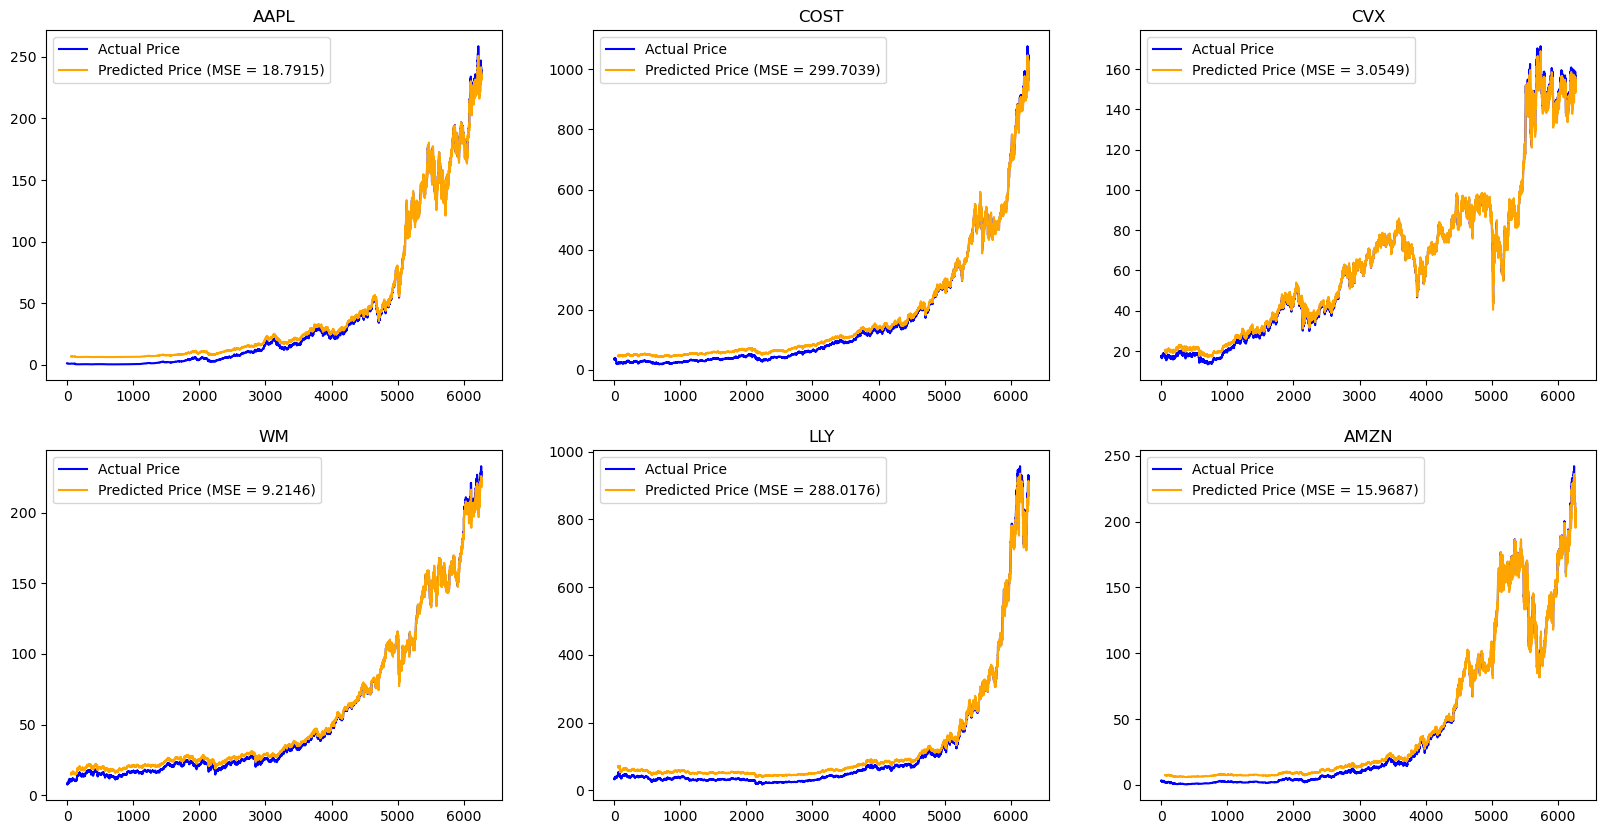

In [49]:
#Create a plot evaluating predicted price vs actual price
tickers.append('AMZN')
LSTM_wrapper.line_plot_evaluation(tickers, '2000-01-01', '2025-03-10')

In [51]:
days_forward = 60
size = 10
df_full = yahoo_interface.single_stock_table('AAPL', '2023-02-02', '2024-01-01')
df_predictor = df_full[:60]

[*********************100%***********************]  1 of 1 completed


In [52]:
#Create forecast ensemble
forecast_list = LSTM_wrapper.forecast_ensemble(df_predictor, days_forward, size)

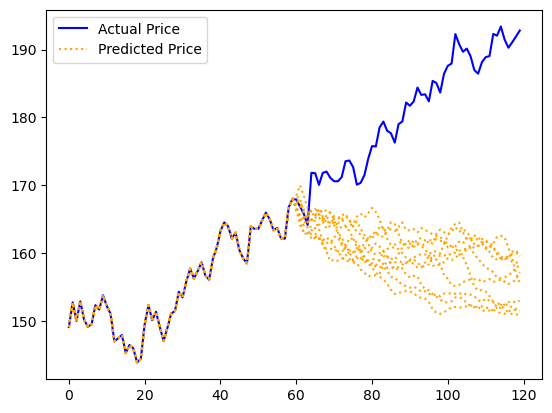

In [54]:
# Plotting real prices
known_plot = np.empty((60 + days_forward, 1))
known_plot[:, :] = np.nan
known_plot[:, :] = df_full['Close'][:60 + days_forward].values.reshape(-1,1)
plt.plot(known_plot, color = 'blue', label = 'Actual Price')


# Plotting predictions
window_size = 60
prediction_plots = []
for j in range(size):
  prediction_plots.append(np.empty((60 + days_forward, 1)))
  prediction_plots[j][:, :] = np.nan
  prediction_plots[j][: window_size + days_forward, :] = forecast_list[j]
  if j == 0:
    plt.plot(prediction_plots[j],  linestyle = ':', color = 'orange', label = 'Predicted Price')
  else:
    plt.plot(prediction_plots[j],  linestyle = ':', color = 'orange')

plt.legend()
plt.show()

Lastly, let's make a Random Forest model.

In [55]:
#Creating training set
tickers = ['AAPL', 'COST', 'CVX', 'WM', 'LLY']
RF_X_train, RF_y_train, RF_X_val, RF_y_val = Random_Forest_Maker.create_training_and_val_sets(tickers, '2000-01-01', '2025-03-10')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [56]:
training_set = [RF_X_train, RF_y_train]

In [57]:
#Create the RF model
Random_Forest_wrapper = Random_Forest_Maker.Random_Forest_wrapper(training_set = training_set)

In [59]:
#Calculate the mean squared error
Random_Forest_wrapper.mse_evaluation(RF_X_val, RF_y_val)

Mean Squared Error (MSE): 0.0005374241576817668
R-squared (R2): 0.9934170659613376


array([0.18579537, 0.16131498, 0.16491275, ..., 0.67124358, 0.68478149,
       0.70267317])

# Conclusion